In [1]:
import time
import csv
from pathlib import Path
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset = mnist.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


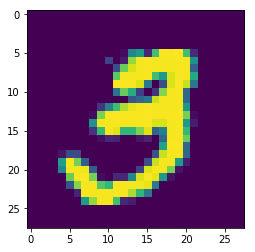

In [4]:
img = np.array(dataset.train.images[753])
plt.imshow(img.reshape(28,28))

In [0]:
def batch_norm(X, scale, offset, axes, is_train, device_name='/cpu:0'):
    # 予測のときにはそのまんまの値を返す
    if is_train is False:
        return X

    epsilon = 1e-5
    with tf.device(device_name):
        mean, variance = tf.nn.moments(X, axes)
        bn = tf.nn.batch_normalization(X, mean, variance, offset, scale, epsilon)
        
    return bn

def global_average_pooling(x):
    for _ in range(1):
        x = tf.reduce_mean(x, axis=[1])
    return x

class Generator():
    def __init__(self, device_name='/cpu:0'):

        # Generator parameter
        with tf.device(device_name):

            self.gen_w0 = tf.Variable(
                tf.random_normal(
                    shape=[50, 4 * 4 * 256], stddev=0.02, dtype=tf.float32),
                name="gen_w0")

            self.gen_b0 = tf.Variable(
                tf.random_normal(
                    shape=[4 * 4 * 256], stddev=0.02, dtype=tf.float32),
                name="gen_b0")

            self.gen_w1 = tf.Variable(
                tf.random_normal(
                    shape=[4, 4, 128, 256], stddev=0.02, dtype=tf.float32),
                name="gen_w1")

            self.gen_b1 = tf.Variable(
                tf.random_normal(shape=[128], stddev=0.02, dtype=tf.float32),
                name="gen_b1")

            self.gen_w2 = tf.Variable(
                tf.random_normal(
                    shape=[4, 4, 64, 128], stddev=0.02, dtype=tf.float32),
                name="gen_w2")

            self.gen_b2 = tf.Variable(
                tf.random_normal(shape=[64], stddev=0.02, dtype=tf.float32),
                name="gen_b2")

            self.gen_w3 = tf.Variable(
                tf.random_normal(
                    shape=[4, 4, 1, 64], stddev=0.02, dtype=tf.float32),
                name="gen_w3")

            self.gen_b3 = tf.Variable(
                tf.random_normal(shape=[1], stddev=0.02, dtype=tf.float32),
                name="gen_b3")

            self.gen_scale_w1 = tf.Variable(
                tf.ones([128]), name="gen_scale_w1")
            self.gen_offset_w1 = tf.Variable(
                tf.zeros([128]), name="gen_offset_w1")

            self.gen_scale_w2 = tf.Variable(
                tf.ones([64]), name="gen_scale_w2")
            self.gen_offset_w2 = tf.Variable(
                tf.zeros([64]), name="gen_offset_w2")

            self.keep_prob = tf.placeholder(tf.float32)
            self.batch_size = tf.placeholder(tf.int32)

    def run(self, z, is_train, device_name='/cpu:0'):

        with tf.device(device_name):

            # fc層で入力を拡張
            h0 = tf.reshape(
                tf.nn.relu(tf.nn.xw_plus_b(z, self.gen_w0, self.gen_b0)),
                [-1, 4, 4, 256])

            gen_conv1 = tf.nn.conv2d_transpose(
                value=h0,
                filter=self.gen_w1,
                output_shape=[self.batch_size, 7, 7, 128],
                strides=[1, 2, 2, 1],
                padding='SAME') + self.gen_b1

            h1 = tf.nn.leaky_relu(
                batch_norm(gen_conv1, self.gen_scale_w1, self.gen_offset_w1,
                           [0, 1, 2], is_train, device_name),
                alpha=0.2)

            gen_conv2 = tf.nn.tanh(
                tf.nn.conv2d_transpose(
                    value=h1,
                    filter=self.gen_w2,
                    output_shape=[self.batch_size, 14, 14, 64],
                    strides=[1, 2, 2, 1],
                    padding='SAME') + self.gen_b2)

            h2 = tf.nn.leaky_relu(
                batch_norm(gen_conv2, self.gen_scale_w2, self.gen_offset_w2,
                           [0, 1, 2], is_train, device_name),
                alpha=0.2)

            gen_conv3 = tf.nn.tanh(
                tf.nn.conv2d_transpose(
                    value=h2,
                    filter=self.gen_w3,
                    output_shape=[self.batch_size, 28, 28, 1],
                    strides=[1, 2, 2, 1],
                    padding='SAME') + self.gen_b3)

        return gen_conv3


class Discrimitor():
    def __init__(self, device_name='/cpu:0'):
        # Discrimitor parameter
        with tf.device(device_name):
            self.dis_w1 = tf.Variable(
                tf.random_normal(
                    shape=[4, 4, 1, 64], stddev=0.02, dtype=tf.float32),
                name="dis_w1")

            self.dis_b1 = tf.Variable(
                tf.random_normal(shape=[64], stddev=0.02, dtype=tf.float32),
                name="dis_b1")

            self.dis_w2 = tf.Variable(
                tf.random_normal(
                    shape=[4, 4, 64, 128], stddev=0.02, dtype=tf.float32),
                name="dis_w2")

            self.dis_b2 = tf.Variable(
                tf.random_normal(shape=[128], stddev=0.02, dtype=tf.float32),
                name="dis_b2")

            self.dis_w3 = tf.Variable(
                tf.random_normal(
                    shape=[4, 4, 128, 256], stddev=0.02, dtype=tf.float32),
                name="dis_w3")

            self.dis_b3 = tf.Variable(
                tf.random_normal(shape=[256], stddev=0.02, dtype=tf.float32),
                name="dis_b3")

            self.dis_w4 = tf.Variable(
                tf.random_normal(
                    shape=[4 * 4 * 256, 1], stddev=0.02, dtype=tf.float32),
                name="dis_w4")

            self.dis_b4 = tf.Variable(
                tf.random_normal(shape=[1], stddev=0.02, dtype=tf.float32),
                name="dis_b4")

    def run(self, x, is_train, device_name='/cpu:0'):

        with tf.device(device_name):
            input_layer = tf.reshape(x, [-1, 28, 28, 1])
            dis_conv1 = tf.nn.conv2d(
                input=input_layer,
                filter=self.dis_w1,
                strides=[1, 2, 2, 1],
                padding='SAME') + self.dis_b1
            h1 = tf.nn.leaky_relu(dis_conv1, alpha=0.2)

            dis_conv2 = tf.nn.conv2d(
                input=h1,
                filter=self.dis_w2,
                strides=[1, 2, 2, 1],
                padding='SAME') + self.dis_b2
            h2 = tf.nn.leaky_relu(dis_conv2, alpha=0.2)

            dis_conv3 = tf.nn.leaky_relu(
                tf.nn.conv2d(
                    input=h2,
                    filter=self.dis_w3,
                    strides=[1, 2, 2, 1],
                    padding='SAME') + self.dis_b3,
                alpha=0.2)

            h3 = tf.nn.leaky_relu(dis_conv3, alpha=0.2)
            # 平坦化
            h3_flat = tf.reshape(h3, [-1, 4 * 4 * 64])
            fc = tf.nn.sigmoid(
                tf.nn.xw_plus_b(
                    h3_flat, weights=self.dis_w4, biases=self.dis_b4))

        return fc


class DCGAN():
    def __init__(self, using_gpu):
        self.device_name = '/cpu:0'
        if (using_gpu):
            self.device_name = '/gpu:0'

        print('using : {}'.format(self.device_name))

        with tf.device(self.device_name):
            self.G_is_train = tf.placeholder(tf.bool)
            self.D_is_train = tf.placeholder(tf.bool)
            self.input_X = tf.placeholder(tf.float32, shape=(None, 28 * 28))

            # t0は0のラベルを格納し、t1は1のラベルを格納する
            self.label_t0 = tf.placeholder(tf.float32, shape=(None, 1))
            self.label_t1 = tf.placeholder(tf.float32, shape=(None, 1))

            # Generator
            self.generator = Generator(device_name=self.device_name)
            # 生成モデルに必要なノイズの入れ物
            self.gen_z = tf.placeholder(tf.float32, shape=(None, 50))
            # Discrimitor
            self.discrimitor = Discrimitor(device_name=self.device_name)

            # weight decay
            gen_norm_term = tf.nn.l2_loss(
                self.generator.gen_w2) + tf.nn.l2_loss(self.generator.gen_w3)
            gen_lambda_ = 0.001

            dis_norm_term = tf.nn.l2_loss(
                self.discrimitor.dis_w2) + tf.nn.l2_loss(
                    self.discrimitor.dis_w3)
            dis_lambda_ = 0.001

            # 訓練データの識別予測
            input_X = self.discrimitor.run(
                self.input_X,
                is_train=self.D_is_train,
                device_name=self.device_name)

            # 生成されたデータの識別予測
            generated_X = self.discrimitor.run(
                self.generator.run(
                    z=self.gen_z,
                    is_train=self.G_is_train,
                    device_name=self.device_name),
                is_train=self.D_is_train,
                device_name=self.device_name)

            self.dis_entropy_X = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.label_t1, logits=input_X)
            self.dis_entropy_G = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.label_t0, logits=generated_X)
            self.dis_loss = tf.reduce_mean(
                self.dis_entropy_X + self.dis_entropy_G
            ) + dis_norm_term * dis_lambda_

            self.gen_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.label_t1, logits=generated_X)
            self.gen_loss = tf.reduce_mean(
                self.gen_entropy) + gen_norm_term * gen_lambda_

            # 最適化する際にDならDのみのパラメータを、GならGのみのパラメータを更新するようにしたいのでモデル別の変数を取得する
            dis_vars = [
                x for x in tf.trainable_variables() if "dis_" in x.name
            ]
            gen_vars = [
                x for x in tf.trainable_variables() if "gen_" in x.name
            ]

            # 識別モデルDの最適化
            self.opt_d = tf.train.AdamOptimizer(
                0.0002, beta1=0.1).minimize(
                    self.dis_loss, var_list=[dis_vars])
            # 生成モデルGの最適化
            self.opt_g = tf.train.AdamOptimizer(
                0.0002, beta1=0.5).minimize(
                    self.gen_loss, var_list=[gen_vars])

    def train(self,
              X_train=None,
              batch_size=100,
              epoch_num=1000,
              imgpath='./mnist_DCGAN_images/',
              ckptpath='./mnist_DCGAN_checkpoints/',
              log_file='mnist_DCGAN_loss_log.csv',
              init=False):

        if X_train is None:
            raise TypeError("X_train is None")

        # 訓練途中で生成データを作成して保存したいのでその保存先の作成
        p = Path(imgpath)
        if not (p.is_dir()):
            p.mkdir()

        # モデルパラメータのチェックポイントの保存先
        ckpt_p = Path(ckptpath)
        if not (ckpt_p.is_dir()):
            ckpt_p.mkdir()

        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        saver = tf.train.Saver()

        sess = tf.Session()

        if (init):
            sess.run(tf.global_variables_initializer())
            print('Initialize')

        ckpt = tf.train.get_checkpoint_state(str(ckpt_p.absolute()))
        if ckpt:
            # checkpointファイルから最後に保存したモデルへのパスを取得する
            last_model = ckpt.model_checkpoint_path
            print("load {0}".format(last_model))
            # 学習済みモデルを読み込む
            saver.restore(sess, last_model)

        step = len(X_train) // batch_size

        # 正解ラベルのミニバッチ
        t1_batch = np.ones((batch_size, 1), dtype=np.float32)
        t0_batch = np.zeros((batch_size, 1), dtype=np.float32)

        for epoch in range(epoch_num):

            perm = np.random.permutation(len(X_train))
            # １エポックごとにかかる時間の計測
            start = time.time()
            for k in range(step):
                #X_batch = mnist.train.next_batch(batch_size)[0] /255.
                X_batch = X_train[perm][k * batch_size:(k + 1) * batch_size]

                # Train Discrimitor
                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(
                    -1, 1, size=[batch_size, 50]).astype(np.float32)

                sess.run(
                    self.opt_d,
                    feed_dict={
                        self.input_X: X_batch,
                        self.D_is_train: True,
                        self.G_is_train: False,
                        self.gen_z: noise_z,
                        self.generator.keep_prob: 1.0,
                        self.generator.batch_size: batch_size,
                        self.label_t1: t1_batch,
                        self.label_t0: t0_batch
                    })

                if k % 1 == 0:
                    # Train Generator
                    # ノイズ事前分布からノイズをミニバッチ分取得
                    noise_z = np.random.uniform(
                        -1, 1, size=[batch_size, 50]).astype(np.float32)
                    sess.run(
                        self.opt_g,
                        feed_dict={
                            self.gen_z: noise_z,
                            self.D_is_train: False,
                            self.G_is_train: True,
                            self.generator.keep_prob: 0.5,
                            self.generator.batch_size: batch_size,
                            self.label_t1: t1_batch
                        })

            # 1epoch終了時の損失を表示
            noise_z = np.random.uniform(
                -1, 1, size=[batch_size, 50]).astype(np.float32)
            train_dis_loss = sess.run(
                self.dis_loss,
                feed_dict={
                    self.input_X: X_batch,
                    self.D_is_train: False,
                    self.G_is_train: False,
                    self.gen_z: noise_z,
                    self.generator.keep_prob: 1.0,
                    self.generator.batch_size: batch_size,
                    self.label_t1: t1_batch,
                    self.label_t0: t0_batch
                })

            train_gen_loss = sess.run(
                self.gen_loss,
                feed_dict={
                    self.gen_z: noise_z,
                    self.D_is_train: False,
                    self.G_is_train: False,
                    self.generator.keep_prob: 1.0,
                    self.generator.batch_size: batch_size,
                    self.label_t1: t1_batch
                })
            print(
                "[Train] epoch: %d, dis loss: %f , gen loss : %f  Time : %f" %
                (epoch, train_dis_loss, train_gen_loss, time.time() - start))

            # ファイルオープン
            f = open(log_file, 'a')
            log_writer = csv.writer(f, lineterminator='\n')
            loss_list = []
            loss_list.append(epoch)
            loss_list.append(train_dis_loss)
            loss_list.append(train_gen_loss)
            # 損失の値を書き込む
            log_writer.writerow(loss_list)
            f.close()

            saver.save(sess, str(ckpt_p.absolute()) + '/GAN-mnist')

            # 2epoch終了毎に生成モデルから5枚の画像を生成する
            if epoch % 2 == 0:
                noise_z = np.random.uniform(
                    -1, 1, size=[5, 50]).astype(np.float32)

                z_const = tf.constant(noise_z, dtype=tf.float32)
                gen_imgs = ((sess.run(
                    self.generator.run(z_const, is_train=False),
                    feed_dict={
                        self.generator.keep_prob: 1.0,
                        self.generator.batch_size: 5
                    }) * 0.5) + 0.5) * 255.
                for i in range(0, 5):
                    Image.fromarray(gen_imgs[i].reshape(
                        28, 28)).convert('RGB').save(
                            str(p.absolute()) +
                            '/generate_img_epoch{0}_{1}.jpg'.format(epoch, i))

In [5]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
# generatorの活性化関数がtanhのため、訓練データも[-1,1]の値を取るように正規化する
X_train = (np.r_[dataset.train.images[np.where(dataset.train.labels[:,3]  > 0)]
                 ,dataset.train.images[np.where(dataset.train.labels[:,5]  > 0)] ] -0.5) / 0.5
#X_train = (mnist.train.images[:20000] - 0.5 ) / 0.5
len(X_train)

10625

In [7]:
model = DCGAN(using_gpu=True)
model.train(
    X_train=X_train,
    batch_size=100,
    epoch_num=51,
    init=True)

using : /gpu:0
Initialize
[Train] epoch: 0, dis loss: 1.336846 , gen loss : 0.571053  Time : 5.354912
[Train] epoch: 1, dis loss: 1.308218 , gen loss : 0.685187  Time : 4.260913
[Train] epoch: 2, dis loss: 1.383322 , gen loss : 0.678038  Time : 4.279759
[Train] epoch: 3, dis loss: 1.387532 , gen loss : 0.691480  Time : 4.306334
[Train] epoch: 4, dis loss: 1.387058 , gen loss : 0.692318  Time : 4.320062
[Train] epoch: 5, dis loss: 1.387245 , gen loss : 0.692169  Time : 4.282522
[Train] epoch: 6, dis loss: 1.386987 , gen loss : 0.692450  Time : 4.339459
[Train] epoch: 7, dis loss: 1.386775 , gen loss : 0.692665  Time : 4.204579
[Train] epoch: 8, dis loss: 1.386654 , gen loss : 0.692786  Time : 4.275939
[Train] epoch: 9, dis loss: 1.386550 , gen loss : 0.692891  Time : 4.323936
[Train] epoch: 10, dis loss: 1.386485 , gen loss : 0.692956  Time : 4.341312
[Train] epoch: 11, dis loss: 1.386428 , gen loss : 0.693013  Time : 4.309191
[Train] epoch: 12, dis loss: 1.386404 , gen loss : 0.693037 

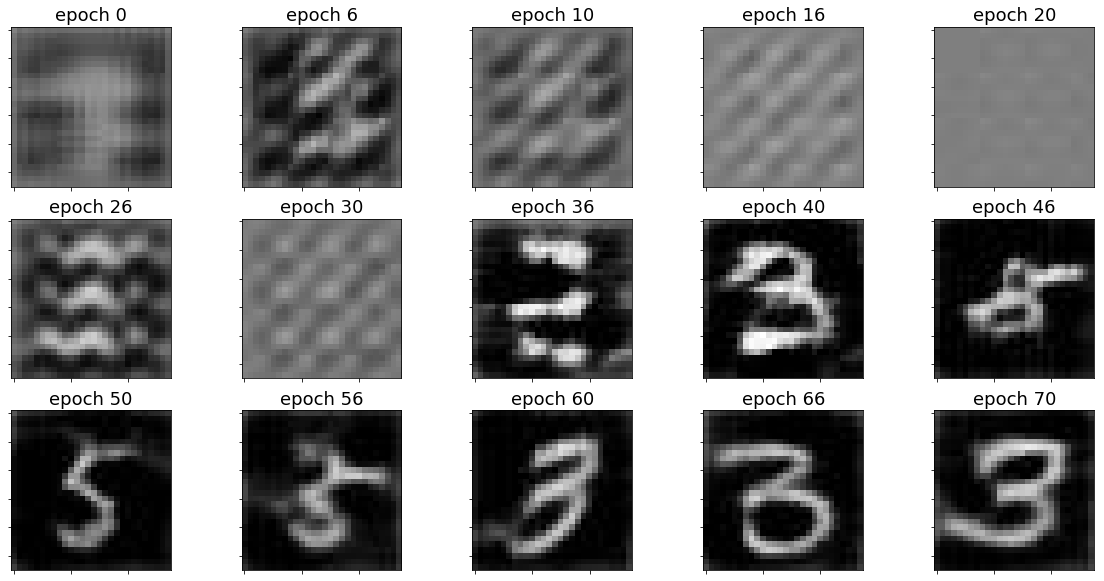

In [3]:
epoch_num = [0,6,10,16,20,26,30,36,40,46,50,56,60,66,70]

plt.figure(figsize=(20,10))
for i,epoch in enumerate(epoch_num):
    img = Image.open('./mnist_DCGAN_images/generate_img_epoch{0}_2.jpg'.format(epoch), 'r')
    # train data plot
    plt.subplot(3, 5, i+1)
    plt.title('epoch {0}'.format(epoch),fontsize=18)
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.imshow(img)

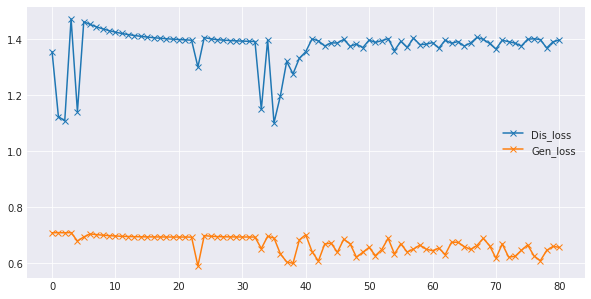

In [9]:
import pandas as pd
df = pd.read_csv('./mnist_DCGAN_loss_log.csv', names=['Epoch', 'Dis_loss','Gen_loss'])
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'],df['Dis_loss'],'-x',label='Dis_loss')
plt.plot(df['Epoch'],df['Gen_loss'],'-x',label='Gen_loss')
plt.legend()
plt.show()